# Fairness!

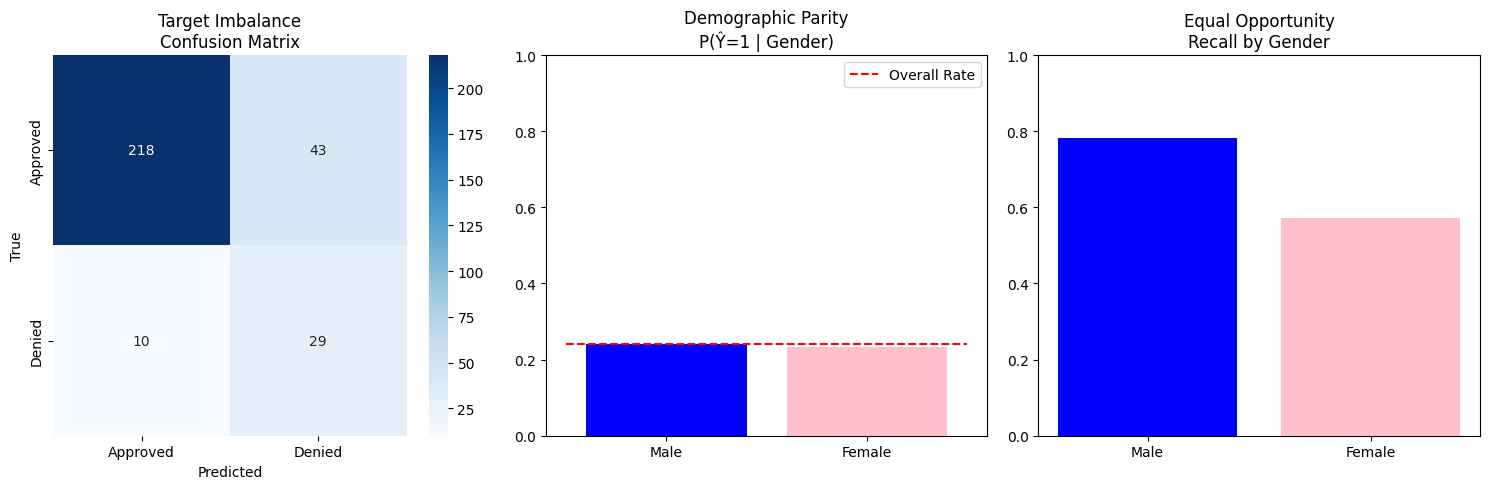

Recall (Target Imbalance): 0.74
Demographic Parity (Male): 0.24
Demographic Parity (Female): 0.23
Equal Opportunity (Male): 0.78
Equal Opportunity (Female): 0.57


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# --- 1. Generate Synthetic Data ---
# Target Imbalance: 90% Approved (0) vs. 10% Denied (1)
# Protected Imbalance: 70% Male (0) vs. 30% Female (1)
n_samples = 1000
X, y = make_classification(
    n_samples=n_samples,
    n_features=5,
    n_classes=2,
    weights=[0.9, 0.1],  # Target imbalance
    flip_y=0.05,
    random_state=42
)
gender = np.random.choice([0, 1], size=n_samples, p=[0.8, 0.2])  # Protected imbalance

# Combine into DataFrame
df = pd.DataFrame(X, columns=[f"Feature_{i}" for i in range(X.shape[1])])
df["Approved"] = y  # Target: 0=Approved, 1=Denied
df["Gender"] = gender  # Protected: 0=Male, 1=Female

# --- 2. Train Model ---
X_train, X_test, y_train, y_test, gender_train, gender_test = train_test_split(
    X, y, gender, test_size=0.3, random_state=42
)
model = LogisticRegression(class_weight="balanced")  # Handle target imbalance
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- 3. Calculate Metrics ---
# Target Imbalance Metrics
cm = confusion_matrix(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Protected Imbalance Metrics
def calculate_fairness_metrics(y_true, y_pred, protected_attr):
    groups = np.unique(protected_attr)
    metrics = {}
    for g in groups:
        mask = (protected_attr == g)
        # Demographic Parity: P(Ŷ=1 | A=g)
        metrics[f"DP_G{g}"] = np.mean(y_pred[mask])
        # Equal Opportunity: P(Ŷ=1 | A=g, Y=1)
        if sum(y_true[mask] == 1) > 0:
            metrics[f"EO_G{g}"] = recall_score(y_true[mask], y_pred[mask])
        else:
            metrics[f"EO_G{g}"] = np.nan
    return metrics

fairness_metrics = calculate_fairness_metrics(y_test, y_pred, gender_test)

# --- 4. Visualizations ---
plt.figure(figsize=(15, 5))

# Plot 1: Target Class Imbalance (Confusion Matrix)
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Approved", "Denied"], 
            yticklabels=["Approved", "Denied"])
plt.title("Target Imbalance\nConfusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

# Plot 2: Protected Attribute Imbalance (Demographic Parity)
plt.subplot(1, 3, 2)
dp_values = [fairness_metrics["DP_G0"], fairness_metrics["DP_G1"]]
plt.bar(["Male", "Female"], dp_values, color=["blue", "pink"])
plt.title("Demographic Parity\nP(Ŷ=1 | Gender)")
plt.ylim(0, 1)
plt.hlines(np.mean(y_pred), -0.5, 1.5, colors="red", linestyles="dashed", label="Overall Rate")
plt.legend()

# Plot 3: Protected Attribute Imbalance (Equal Opportunity)
plt.subplot(1, 3, 3)
eo_values = [fairness_metrics["EO_G0"], fairness_metrics["EO_G1"]]
plt.bar(["Male", "Female"], eo_values, color=["blue", "pink"])
plt.title("Equal Opportunity\nRecall by Gender")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Print Metrics
print(f"Recall (Target Imbalance): {recall:.2f}")
print(f"Demographic Parity (Male): {fairness_metrics['DP_G0']:.2f}")
print(f"Demographic Parity (Female): {fairness_metrics['DP_G1']:.2f}")
print(f"Equal Opportunity (Male): {fairness_metrics['EO_G0']:.2f}")
print(f"Equal Opportunity (Female): {fairness_metrics['EO_G1']:.2f}")

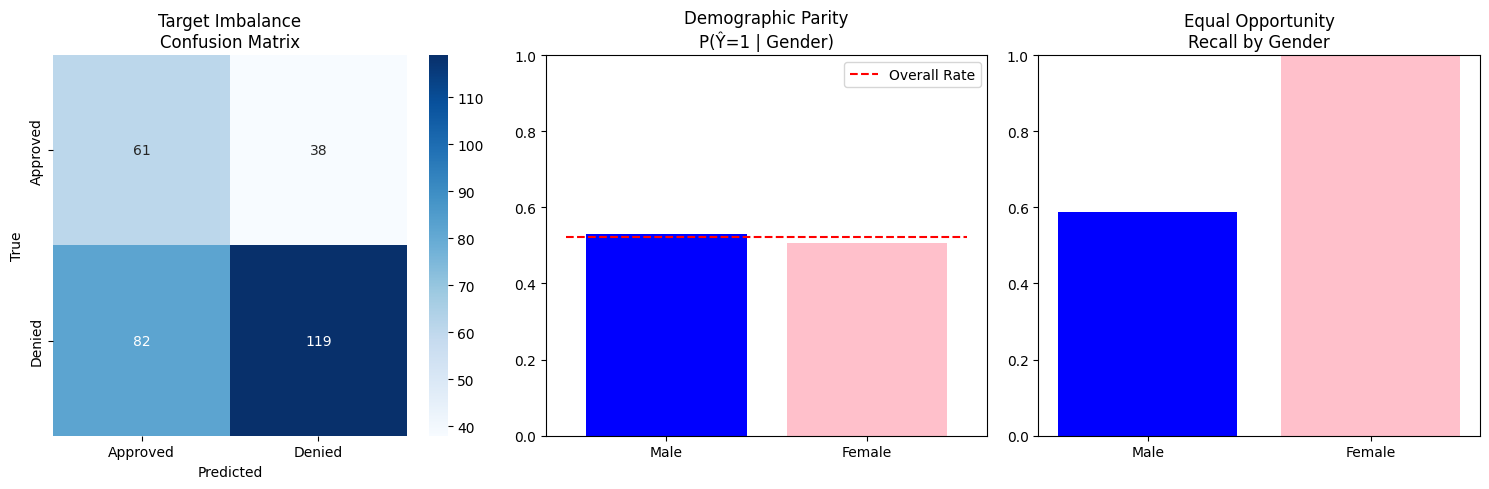

Recall (Target Imbalance): 0.59
Demographic Parity (Male): 0.53
Demographic Parity (Female): 0.51
Equal Opportunity (Male): 0.59
Equal Opportunity (Female): 1.00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# --- 1. Generate Synthetic Data with Gender Bias ---
n_samples = 1000
X, y = make_classification(
    n_samples=n_samples,
    n_features=5,
    n_classes=2,
    weights=[0.5, 0.5],  # Target imbalance: 90% Approved, 10% Denied
    flip_y=0.05,
    random_state=42
)

# Introduce gender bias: Males (0) are more likely to be approved
gender = np.random.choice([0, 1], size=n_samples, p=[0.7, 0.3])  # 70% Male, 30% Female
bias_term = np.where(gender == 0, 0.3, -0.5)  # Males get +0.3 bias, Females -0.5
y_biased = (X.mean(axis=1) + bias_term + np.random.normal(0, 0.1, n_samples) > 0).astype(int)

# Combine into DataFrame
df = pd.DataFrame(X, columns=[f"Feature_{i}" for i in range(X.shape[1])])
df["Approved"] = y_biased  # Biased target
df["Gender"] = gender  # Protected: 0=Male, 1=Female

# --- 2. Train Model ---
X_train, X_test, y_train, y_test, gender_train, gender_test = train_test_split(
    X, y_biased, gender, test_size=0.3, random_state=42
)
model = LogisticRegression(class_weight="balanced")  # Handle target imbalance
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- 3. Calculate Metrics ---
# Target Imbalance Metrics
cm = confusion_matrix(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Protected Imbalance Metrics
def calculate_fairness_metrics(y_true, y_pred, protected_attr):
    groups = np.unique(protected_attr)
    metrics = {}
    for g in groups:
        mask = (protected_attr == g)
        # Demographic Parity: P(Ŷ=1 | A=g)
        metrics[f"DP_G{g}"] = np.mean(y_pred[mask])
        # Equal Opportunity: P(Ŷ=1 | A=g, Y=1)
        if sum(y_true[mask] == 1) > 0:
            metrics[f"EO_G{g}"] = recall_score(y_true[mask], y_pred[mask])
        else:
            metrics[f"EO_G{g}"] = np.nan
    return metrics

fairness_metrics = calculate_fairness_metrics(y_test, y_pred, gender_test)

# --- 4. Visualizations ---
plt.figure(figsize=(15, 5))

# Plot 1: Target Class Imbalance (Confusion Matrix)
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Approved", "Denied"], 
            yticklabels=["Approved", "Denied"])
plt.title("Target Imbalance\nConfusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

# Plot 2: Demographic Parity (Gender Bias)
plt.subplot(1, 3, 2)
dp_values = [fairness_metrics["DP_G0"], fairness_metrics["DP_G1"]]
plt.bar(["Male", "Female"], dp_values, color=["blue", "pink"])
plt.title("Demographic Parity\nP(Ŷ=1 | Gender)")
plt.ylim(0, 1)
plt.hlines(np.mean(y_pred), -0.5, 1.5, colors="red", linestyles="dashed", label="Overall Rate")
plt.legend()

# Plot 3: Equal Opportunity (Gender Bias)
plt.subplot(1, 3, 3)
eo_values = [fairness_metrics["EO_G0"], fairness_metrics["EO_G1"]]
plt.bar(["Male", "Female"], eo_values, color=["blue", "pink"])
plt.title("Equal Opportunity\nRecall by Gender")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Print Metrics
print(f"Recall (Target Imbalance): {recall:.2f}")
print(f"Demographic Parity (Male): {fairness_metrics['DP_G0']:.2f}")
print(f"Demographic Parity (Female): {fairness_metrics['DP_G1']:.2f}")
print(f"Equal Opportunity (Male): {fairness_metrics['EO_G0']:.2f}")
print(f"Equal Opportunity (Female): {fairness_metrics['EO_G1']:.2f}")